# 0 Configuration

In [1]:
config = {
    "overview": {

    },
    "fe": {
        "id": False, # true
        "volume": False,
        "order_purchase_timestamp": False, # linked with 'shipping_limit_date'
        "shipping_limit_date": False,
        "order_estimated_delivery_date": False,
        "price_agg": False, # false
        "last_order_datetime": False,
        "frequency": False
    },
    "model": {
        "rfm_raw": {
            "preparation": True,
            "n_cluster": False,
            "silhouette": False,
            "explain": True
        },
        "rfm_scored": {
            "do": False,
            "silhouette": False
        },
        "personae": {
            "do": True
        }
    },
    "pca": {
        "do": False
    }
}

***
# 1 Dependencies import

## 1.0 Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

from math import ceil

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

np.random.seed(0)

***
## 1.1 Features selection

In [3]:
def get_categorical_features_name(dataset, split_by_unique_count=True, split_count=10):
    features_name = dataset.select_dtypes(["object", "bool"]).columns
    if split_by_unique_count:
        less_uniques = [feature_name for feature_name in features_name if dataset[feature_name].nunique() <= split_count]
        lot_uniques = features_name.difference(less_uniques).tolist()
        return (less_uniques, lot_uniques)
    else:
        return features_name.values.tolist()

In [4]:
def get_numerical_features_name(dataset):
    features_name = dataset.select_dtypes(["int64", "float64"]).columns.values.tolist()
    return features_name

In [5]:
def progressiveFeatureSelection(df, n_clusters=3, max_features=4,):
    feature_list = list(df.columns)
    selected_features = list()
    # select starting feature
    initial_feature = ""
    high_score = 0
    for feature in feature_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        data_ = df[feature]
        labels = kmeans.fit_predict(data_.to_frame())
        score_ = silhouette_score(data_.to_frame(), labels)
        print("Proposed new feature {} with score {}". format(feature, score_))
        if score_ >= high_score:
            initial_feature = feature
            high_score = score_
    print("The initial feature is {} with a silhouette score of {}.".format(initial_feature, high_score))
    feature_list.remove(initial_feature)
    selected_features.append(initial_feature)
    for _ in range(max_features-1):
        high_score = 0
        selected_feature = ""
        print("Starting selection {}...".format(_))
        for feature in feature_list:
            selection_ = selected_features.copy()
            selection_.append(feature)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            data_ = df[selection_]
            labels = kmeans.fit_predict(data_)
            score_ = silhouette_score(data_, labels)
            print("Proposed new feature {} with score {}". format(feature, score_))
            if score_ > high_score:
                selected_feature = feature
                high_score = score_
        selected_features.append(selected_feature)
        feature_list.remove(selected_feature)
        print("Selected new feature {} with score {}". format(selected_feature, high_score))
    return selected_features

***
## 1.2 Pipeline construction

In [6]:
def evaluate(dataset, model, scoring="neg_root_mean_squared_error"):

    ### DATASET PREPARATION ###

    # categorical_cols = get_categorical_features_name(dataset, split_by_unique_count=False)
    numerical_cols = get_numerical_features_name(dataset)

    # X = dataset[numerical_cols + categorical_cols]
    X = dataset[numerical_cols]

    ### PIPELINE CONSTRUCTION ###

    num_pipe = Pipeline(steps=[
        ("simple_imputer", SimpleImputer(strategy="mean")),
        ("minmax_scaler", StandardScaler())
    ])

    # cat_pipe = Pipeline(steps=[
    #     ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    #     ("ordinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    #     ("simple_imputer_bis", SimpleImputer(strategy="mean")),
    #     ("std_scaler", StandardScaler())
    # ])

    preprocessor = ColumnTransformer([
        ("num_pipe", num_pipe, numerical_cols),
        # ("cat_pipe", cat_pipe, categorical_cols)
    ])

    pipeline = Pipeline([
        ("transforms", preprocessor),
        ("model", model)
    ])

    preprocessor.fit(X)
    array_preproc = preprocessor.transform(X)
    data_preproc = pd.DataFrame(data=array_preproc, columns=X.columns)

    return pipeline, preprocessor, data_preproc

In [7]:
def pca_preprocessor(dataset):
    num_cols = get_numerical_features_name(dataset)
    categ_cols, _ = get_categorical_features_name(dataset)

    num_pipe = Pipeline(steps=[
        ("imputer_01", SimpleImputer(strategy="mean")),
        ("scaler_01", StandardScaler())
    ])

    categ_pipe = Pipeline(steps=[
        ("imputer_01", SimpleImputer(strategy="most_frequent")),
        ("encoder_01", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num_pipe", num_pipe, num_cols),
        ("categ_pipe", categ_pipe, categ_cols)
    ])

    return preprocessor, num_cols, categ_cols

In [8]:
def preprocess_data(dataset):
    preprocessor, num_cols, categ_cols = pca_preprocessor(dataset)

    raw_preprocessed_data = preprocessor.fit_transform(dataset)

    if categ_cols:
        categ_cols_preprocessed = preprocessor.transformers_[1][1]["encoder_01"].get_feature_names_out(categ_cols).tolist()
    else:
        categ_cols_preprocessed = []

    col_names = num_cols + categ_cols_preprocessed

    preprocessed_data = pd.DataFrame(data=raw_preprocessed_data, columns=col_names)

    return preprocessed_data

***
## 1.3 Cluster evaluation

In [9]:
def elbow_plot(range, data, figsize=(10,10)):
    intertia_list = []
    for n in range:
        kmeans = KMeans(n_clusters=n, random_state=1)
        kmeans.fit(data)
        intertia_list.append(kmeans.inertia_)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.lineplot(y=intertia_list, x=range, ax=ax)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Inertia")
    ax.set_xticks(list(range))
    fig.show()

In [10]:
def silhouette_plot(range, data, n_cols=2, figsize=(20, 10), wspace=0.35, hspace=0.35):
    if range[0] == 0:
        raise Exception("Range must not include 0")

    n_rows = ceil(len(range)/n_cols)
    index = 0

    plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    for n in range:
        kmeans = KMeans(n, random_state=1)

        plt.subplot(n_rows, n_cols, index+1)
        sv = SilhouetteVisualizer(kmeans, colors="yellowbrick")
        sv.fit(data)

        index += 1
    
    plt.show()

In [11]:
def find_optimal_epsilon(n_neighbors, data):
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

***
## 1.4 Dimensionality reduction

In [12]:
def scree_plot(dataset, figsize=(15, 5)):
    pca = PCA()
    pca.fit(dataset)

    plt.figure(figsize=figsize)
    explain_variance = pd.Series(pca.explained_variance_ratio_)
    explain_variance.plot(kind="bar", alpha=0.7)

    total = 0
    var_ls = []
    for x in explain_variance:
        total = total + x
        var_ls.append(total)
    
    pd.Series(var_ls).plot(marker="o", alpha=0.7)
    plt.xlabel("Principle Components", fontsize="x-large")
    plt.ylabel("Percentage Variance Explained", fontsize="x-large")
    plt.title("Scree plot", fontsize="xx-large")
    plt.show()

    return pca

In [13]:
def apply_pca(dataset, columns, n_components):
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(dataset[columns])
    components_name = [f"PC{i+1}" for i in range(pca_data.shape[1])]
    pca_data = pd.DataFrame(data=pca_data, columns=components_name)
    loadings = pd.DataFrame(data=pca.components_.T, columns=components_name, index=columns)
    return pca, pca_data, loadings

In [14]:
def plot_variance(pca, width=8, dpi=100):
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    evr = pca.explained_variance_ratio_

    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )

    cumulative_variance = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cumulative_variance], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )

    fig.set(figwidth=8, dpi=100)
    return axs

***
## 1.5 RFM

In [15]:
def rfm_distplot(dataset, customer_id, figsize=(20, 5)):
    warnings.filterwarnings('ignore')
    dataset = dataset.loc[:, dataset.columns.difference(customer_id)]

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    for i, feature in enumerate(dataset.columns):
        sns.distplot(dataset[feature], ax=axes[i])

In [16]:
def correlation_heatmap(dataset, figsize=(30, 20)):
    plt.figure(figsize=figsize)

    correlation = dataset.corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    sns.heatmap(data=correlation, mask=mask, annot=True, vmax=.75, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title("Correlation heatmap", size=20)
    plt.xticks(rotation=45, size=16, ha="right")
    plt.yticks(size=16)
    plt.show()

In [17]:
def elbow(dataset, k=(2, 12)):
    model = KMeans(random_state=1)
    elbow_visualizer = KElbowVisualizer(model, k=k)

    elbow_visualizer.fit(dataset)
    elbow_visualizer.poof()

In [18]:
def silhouette(dataset, n):
    model = KMeans(n, random_state=1)
    silhouette_visualizer = SilhouetteVisualizer(model)

    silhouette_visualizer.fit(dataset)
    silhouette_visualizer.poof()

In [19]:
def explain(dataset, dataset_preproc):
    model = KMeans(n_clusters=4, random_state=1).fit(dataset_preproc)
    data_explain = dataset
    data_explain["Cluster"] = model.labels_

    data_explain_melt = pd.melt(data_explain, id_vars=["customer_id", "Cluster"], value_vars=["Récence", "Fréquence", "Montant"], var_name="Features", value_name="Value")
    sns.lineplot("Features", "Value", hue="Cluster", data=data_explain_melt)
    plt.legend()

    return data_explain.groupby("Cluster").agg({
    "Récence": ["mean", "min", "max"],
    "Fréquence": ["mean", "min", "max"],
    "Montant": ["mean", "min", "max", "count"]
})

***
# 2 Data loading

In [20]:
data = pd.read_csv("data/data_cleaned.csv", delimiter=",")

In [21]:
# data = pd.read_csv("data/data_cleaned.csv", delimiter=",", parse_dates=["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date", "review_creation_date", "review_answer_timestamp", "shipping_limit_date"], infer_datetime_format=True)

***
# 3 Overview

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111705 entries, 0 to 111704
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       111705 non-null  object 
 1   customer_id                    111705 non-null  object 
 2   order_status                   111705 non-null  object 
 3   order_purchase_timestamp       111705 non-null  object 
 4   order_approved_at              111690 non-null  object 
 5   order_delivered_carrier_date   110530 non-null  object 
 6   order_delivered_customer_date  109366 non-null  object 
 7   order_estimated_delivery_date  111705 non-null  object 
 8   customer_unique_id             107697 non-null  object 
 9   customer_zip_code_prefix       107697 non-null  float64
 10  customer_city                  107697 non-null  object 
 11  customer_state                 107697 non-null  object 
 12  review_id                     

In [23]:
data.describe()

,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix
count,107697.000000,111705.000000,111705.000000,111702.000000,111705.00000,111705.000000,111705.000000,111323.000000,110116.000000,110116.000000,110116.000000,111679.000000,111687.000000,111687.000000,111687.000000,111705.000000
mean,35174.843524,4.033597,1.022640,3.000116,177.04113,1.195273,120.556914,20.057779,48.776390,787.762478,2.209988,2092.554187,30.143616,16.586111,22.994332,24447.946896
std,29885.219509,1.387014,0.256334,2.794302,269.13137,0.689177,182.507246,15.788333,10.025996,651.996358,1.721755,3750.548184,16.141022,13.442283,11.706423,27605.113502
min,1003.000000,1.000000,1.000000,1.000000,0.01000,1.000000,0.850000,0.010000,5.000000,4.000000,1.000000,2.000000,7.000000,2.000000,6.000000,1001.000000
25%,11340.000000,4.000000,1.000000,1.000000,64.01000,1.000000,39.900000,13.085000,42.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000
50%,24350.000000,5.000000,1.000000,2.000000,112.42000,1.000000,74.990000,16.290000,52.000000,602.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13566.000000
75%,59075.000000,5.000000,1.000000,4.000000,193.32000,1.000000,134.900000,21.160000,57.000000,986.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,28035.000000
max,99990.000000,5.000000,27.000000,24.000000,13664.08000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000


In [24]:
data.describe(include="object")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,review_id,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_type,product_id,seller_id,shipping_limit_date,product_category_name,seller_city,seller_state
count,111705,111705,111705,111705,111690,110530,109366,111705,107697,107697,107697,111705,13416,47402,111705,111705,111705,111705,111705,111705,110116,111705,111705
unique,97916,97916,7,97370,89533,80449,95021,449,94655,4107,27,97454,4495,35618,632,97292,4,32789,3090,92642,73,611,23
top,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2018-02-24 03:20:27,2018-05-09 15:48:00,2017-07-31 18:03:02,2017-12-20 00:00:00,4546caea018ad8c692964e3382debd19,sao paulo,SP,e8236fe7b6e1bdd513a500de361e2b87,Recomendo,Muito bom,2017-12-19 00:00:00,2017-07-30 14:19:07,credit_card,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23,cama_mesa_banho,sao paulo,SP
freq,21,21,109367,21,23,48,21,600,21,16966,45365,21,468,253,513,21,84471,524,2014,21,10982,27745,79661


***
# 4 Feeture engineering

## 4.0 Remove *_id

In [25]:
def fe_id_remove(dataset, diff=[]):
    id_cols = dataset.columns[dataset.columns.str.contains("_id")]
    id_cols = id_cols.difference(diff)
    dataset.drop(columns=id_cols, inplace=True)
    return dataset

***
## 4.1 Volume

In [26]:
def fe_volume(dataset):
    dataset["product_volume_cm3"] = dataset["product_length_cm"] * dataset["product_height_cm"] * dataset["product_width_cm"]
    return dataset

***
## 4.2 Order purchase timestamp

In [27]:
def fe_purchase_timestamp(dataset):
    dataset.loc[:, "order_purchase_timestamp"] = dataset.loc[:, "order_purchase_timestamp"].apply(pd.to_datetime)
    opt = dataset.loc[:, "order_purchase_timestamp"]
    dataset["order_purchase_year"] = opt.dt.year
    dataset["order_purchase_month"] = opt.dt.month
    dataset["order_purchase_day"] = opt.dt.day
    dataset["order_purchase_hour"] = opt.dt.hour

    display = dataset.loc[:, ["order_purchase_timestamp", "order_purchase_year", "order_purchase_month", "order_purchase_day", "order_purchase_hour"]].head()
    return dataset

***
## 4.3 Shipping limit date

In [28]:
def fe_shipping_date(dataset):
    dataset.loc[:, "shipping_limit_date"] = dataset.loc[:, "shipping_limit_date"].apply(pd.to_datetime)
    sld = data.loc[:, "shipping_limit_date"]
    dataset["shipping_limit_year"] = sld.dt.year
    dataset["shipping_limit_month"] = sld.dt.month
    dataset["shipping_limit_day"] = sld.dt.day
    dataset["shipping_limit_hour"] = sld.dt.hour

    display = dataset.loc[:, ["shipping_limit_date", "shipping_limit_year", "shipping_limit_month", "shipping_limit_day", "shipping_limit_hour"]].head()
    return dataset

***
## 4.4 Estimated delivery date

In [29]:
def fe_delivery_date(dataset):
    dataset.loc[:, "order_estimated_delivery_date"] = dataset.loc[:, "order_estimated_delivery_date"].apply(pd.to_datetime)
    oedd = dataset.loc[:, "order_estimated_delivery_date"]
    dataset["order_estimated_delivery_year"] = oedd.dt.year
    dataset["order_estimated_delivery_month"] = oedd.dt.month
    dataset["order_estimated_delivery_day"] = oedd.dt.day
    dataset["order_estimated_delivery_hour"] = oedd.dt.hour

    display = dataset.loc[:, ["order_estimated_delivery_date", "order_estimated_delivery_year", "order_estimated_delivery_month", "order_estimated_delivery_day", "order_estimated_delivery_hour"]].head()
    return dataset

***
## 4.5 Price agg

In [30]:
def fe_price(dataset):
    customer_price_agg = dataset.groupby("customer_id").agg({
        "price": ["min", "max", "mean", "sum"]
    })

    customer_price_agg.rename(columns={
        "min": "price_min",
        "max": "price_max",
        "mean": "price_mean",
        "sum": "price_sum"
    }, inplace=True)

    dataset = dataset.merge(customer_price_agg.price, on="customer_id")
    display = dataset.loc[:, ["customer_id", "price_min", "price_max", "price_mean", "price_sum"]].head()
    return dataset


***
## 4.6 Last order datetime

In [31]:
def fe_recency(dataset):
    dataset.loc[:, "order_purchase_timestamp"] = dataset.loc[:, "order_purchase_timestamp"].apply(pd.to_datetime)
    data_end = max(dataset.loc[:, "order_purchase_timestamp"] + pd.Timedelta(days=1))

    opt_agg = dataset.groupby("customer_id").agg({
        "order_purchase_timestamp": lambda x: (data_end - max(x)).days
    })

    opt_agg.columns = ["recency"]
    opt_agg = opt_agg.reset_index()

    dataset = dataset.merge(opt_agg, on="customer_id")

    display = dataset.loc[:, ["customer_id", "order_purchase_timestamp", "recency"]].head()
    return dataset

***
## 4.7 Frequency

In [32]:
def fe_frequency(dataset):
    frequency = dataset.groupby("customer_id").agg({
        "order_id": ["count"]
    })

    frequency = frequency.order_id.reset_index()
    frequency.columns = ["customer_id", "frequency"]
    
    dataset = dataset.merge(frequency, how="left", on="customer_id")
    display = dataset.loc[:, ["customer_id", "frequency"]].head()
    return dataset

***
# 5 Modelisation

## 5.1 RFM

### 5.1.1 Preparation

RFM: Récence (dat de la dernière commande), Fréquence (des commandes), Montant (de la dernière commande ou sur une période donnée)

In [33]:
if config["model"]["rfm_raw"]["preparation"]:
    rfm_cols = ["customer_id","order_purchase_timestamp", "order_id", "price"]
    data = data.loc[:, rfm_cols]

In [34]:
if config["model"]["rfm_raw"]["preparation"]:
    data = fe_id_remove(data, diff=["customer_id", "order_id", "product_id"])
    data = fe_recency(data)
    data = fe_price(data)
    data = fe_frequency(data)

In [35]:
if config["model"]["rfm_raw"]["preparation"]:
    data.drop(columns=["price", "price_min", "price_max", "price_mean", "order_purchase_timestamp", "order_id"], inplace=True)
    data.rename(columns={"recency": "Récence", "price_sum": "Montant", "frequency": "Fréquence"}, inplace=True)

In [36]:
display = None
if config["model"]["rfm_raw"]["preparation"]:
    display = data.describe()
display

,Récence,Montant,Fréquence
count,111705.000000,111705.000000,111705.000000
mean,245.546627,152.510902,1.390547
std,153.175536,255.845057,1.091553
min,1.000000,0.850000,1.000000
25%,122.000000,49.000000,1.000000
50%,226.000000,91.280000,1.000000
75%,355.000000,164.900000,1.000000
max,729.000000,13440.000000,21.000000


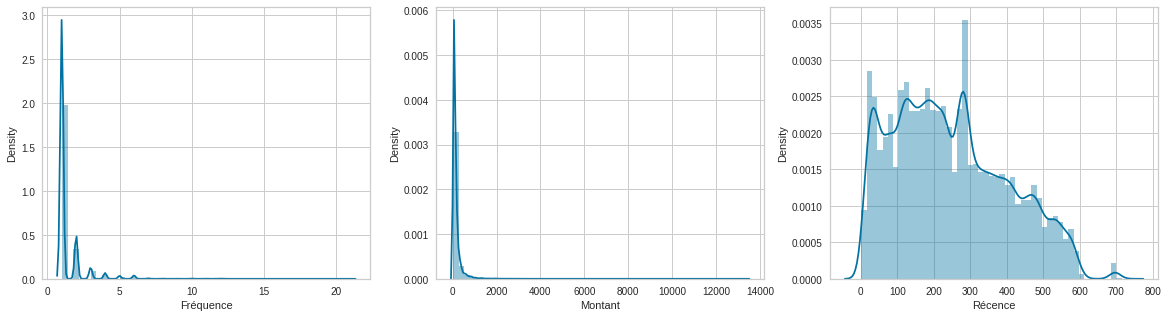

In [37]:
if config["model"]["rfm_raw"]["preparation"]:
    rfm_distplot(data, ["customer_id"])

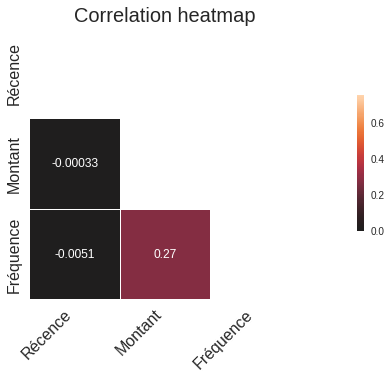

In [38]:
if config["model"]["rfm_raw"]["preparation"]:
    correlation_heatmap(data, figsize=(20, 5))

In [39]:
if config["model"]["rfm_raw"]["preparation"]:

    model = KMeans(n_clusters=4)

    pipeline, preproc, data_preproc = evaluate(data.copy(), model)

In [40]:
display = None
if config["model"]["rfm_raw"]["preparation"]:
    display = data_preproc.head()
display

,Récence,Montant,Fréquence
count,111705.000000,111705.000000,111705.000000
mean,245.546627,152.510902,1.390547
std,153.175536,255.845057,1.091553
min,1.000000,0.850000,1.000000
25%,122.000000,49.000000,1.000000
50%,226.000000,91.280000,1.000000
75%,355.000000,164.900000,1.000000
max,729.000000,13440.000000,21.000000


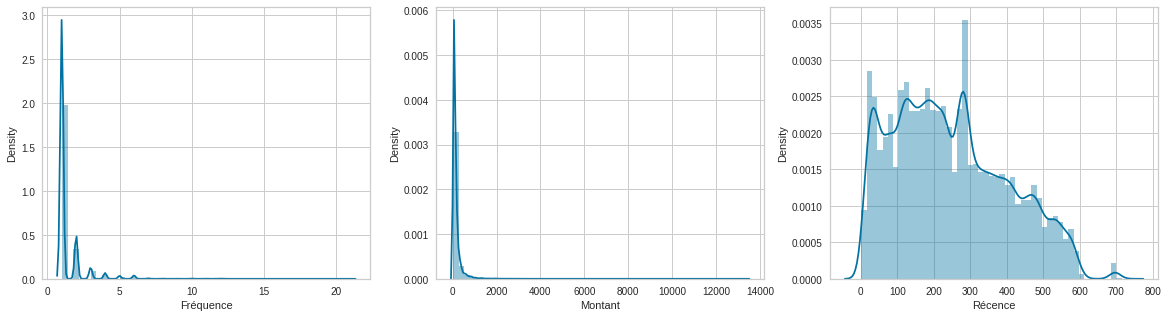

In [41]:
if config["model"]["rfm_raw"]["preparation"]:
    rfm_distplot(data_preproc, ["customer_id"])

***
### 5.1.2 Cluster N analysis

In [42]:
if config["model"]["rfm_raw"]["n_cluster"]:
    elbow(data_preproc.copy(), (2, 12))

In [43]:
if config["model"]["rfm_raw"]["silhouette"]:
    silhouette(data_preproc.copy(), 4)

,Récence,Montant,Fréquence
0,0.590524,-0.478889,-0.357791
1,0.903891,-0.478889,-0.357791
2,0.988761,-0.478889,-0.357791
3,0.453425,-0.478889,-0.357791
4,0.936533,-0.299444,-0.357791


Silhouette for n=4  
![alt text](plots/kmeans_4n.png "Silhouette for n=4")

***
### 5.1.3 Explaination

Récence           Fréquence              Montant                   \
               mean  min  max      mean min max         mean     min      max   
Cluster                                                                         
0        394.290283  264  729  1.213084   1   4   122.891356    2.29    890.0   
1        242.267869    6  699  5.400515   3  21   358.137291   17.50   2000.0   
2        134.403872    1  264  1.205660   1   3   122.294499    0.85    859.9   
3        244.760274    9  699  1.687422   1  10  1523.029315  819.89  13440.0   

                
         count  
Cluster         
0        45156  
1         4659  
2        60284  
3         1606

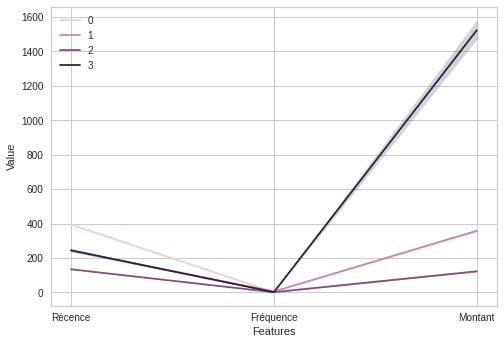

In [44]:
display = None
if config["model"]["rfm_raw"]["explain"]:
    display = explain(data, data_preproc)
display

In [45]:
pred = KMeans(n_clusters=4, random_state=1).fit_predict(data_preproc)

<AxesSubplot:xlabel='Montant', ylabel='Montant'>

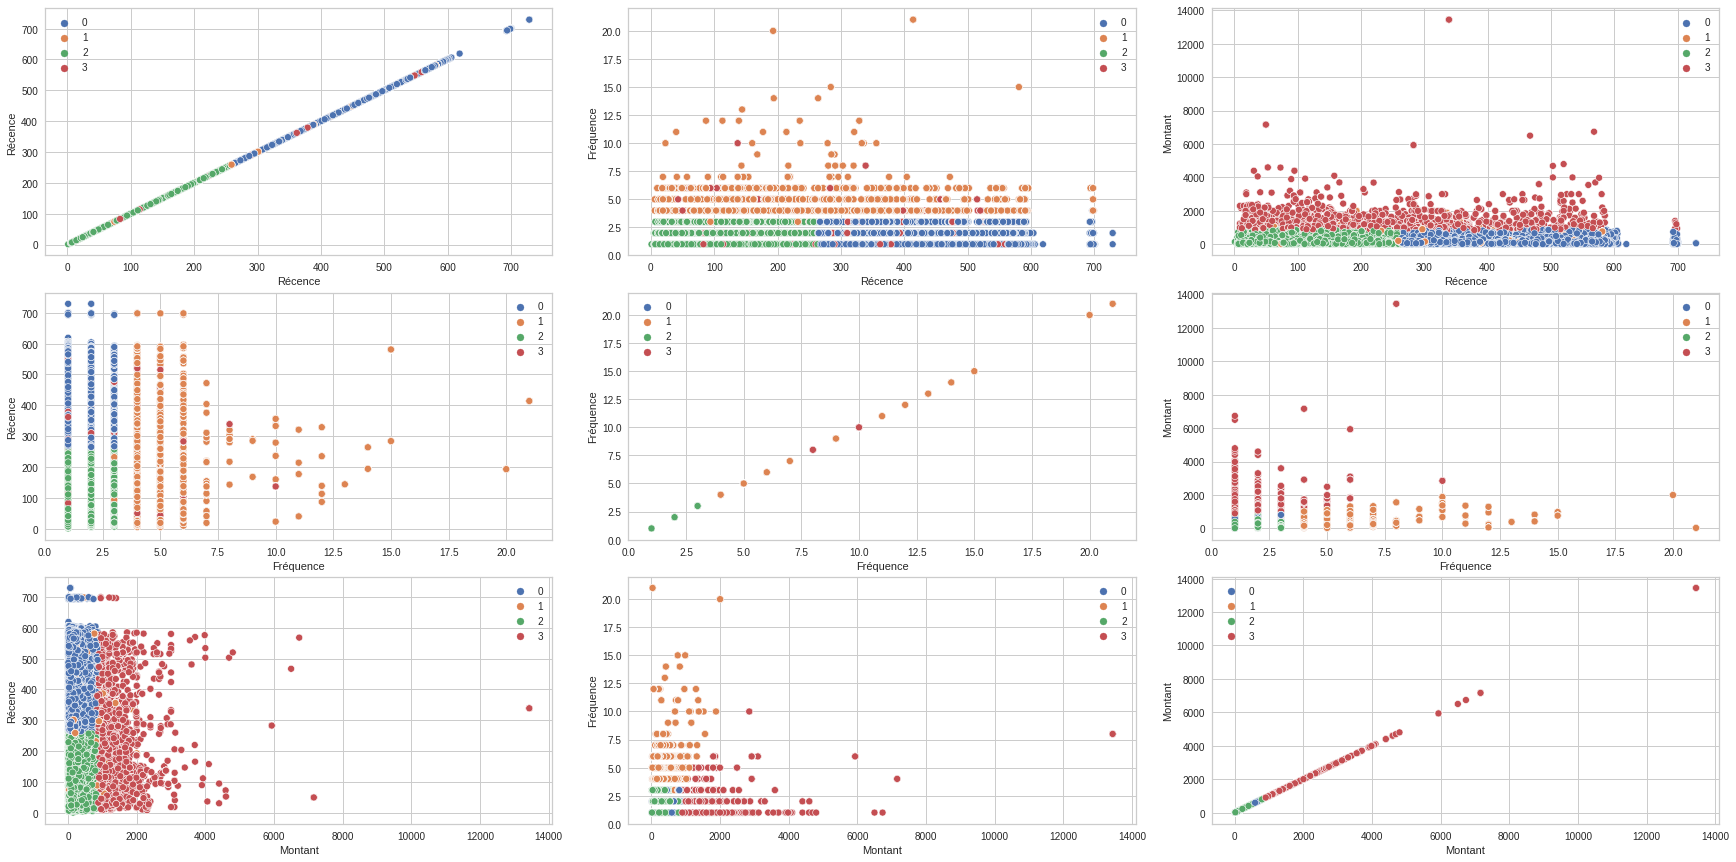

In [46]:
plt.subplots(3, 3, figsize=(30, 15))
plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.subplot(3 ,3, 1)
sns.scatterplot(x=data["Récence"], y=data["Récence"], hue=pred, palette="deep")

plt.subplot(3 ,3, 2)
sns.scatterplot(x=data["Récence"], y=data["Fréquence"], hue=pred, palette="deep")

plt.subplot(3 ,3, 3)
sns.scatterplot(x=data["Récence"], y=data["Montant"], hue=pred, palette="deep")

plt.subplot(3 ,3, 4)
sns.scatterplot(x=data["Fréquence"], y=data["Récence"], hue=pred, palette="deep")

plt.subplot(3 ,3, 5)
sns.scatterplot(x=data["Fréquence"], y=data["Fréquence"], hue=pred, palette="deep")

plt.subplot(3 ,3, 6)
sns.scatterplot(x=data["Fréquence"], y=data["Montant"], hue=pred, palette="deep")

plt.subplot(3 ,3, 7)
sns.scatterplot(x=data["Montant"], y=data["Récence"], hue=pred, palette="deep")

plt.subplot(3 ,3, 8)
sns.scatterplot(x=data["Montant"], y=data["Fréquence"], hue=pred, palette="deep")

plt.subplot(3 ,3, 9)
sns.scatterplot(x=data["Montant"], y=data["Montant"], hue=pred, palette="deep")

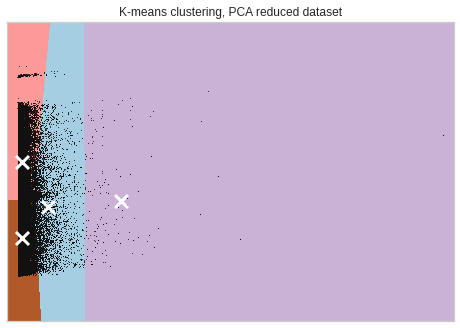

In [62]:
## PCA reduced visualization

# pca = PCA(n_components=2).fit(data_preproc)
# reduced_data = pca.transform(data_preproc)
pca, pca_data, loadings = apply_pca(data_preproc, data_preproc.columns, 2)
reduced_data = pca_data.to_numpy()
model = KMeans(init="k-means++", n_clusters=4)
model.fit(reduced_data)

h = 0.02

x_min = reduced_data[:, 0].min() - 1
x_max = reduced_data[:, 0].max() + 1

y_min = reduced_data[:, 1].min() - 1
y_max = reduced_data[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z, interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower"
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

centroids = model.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10
)

plt.title("K-means clustering, PCA reduced dataset")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [63]:
loadings

,PC1,PC2
Récence,-0.014175,0.999822
Montant,0.706973,0.018813
Fréquence,0.707098,0.001232


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

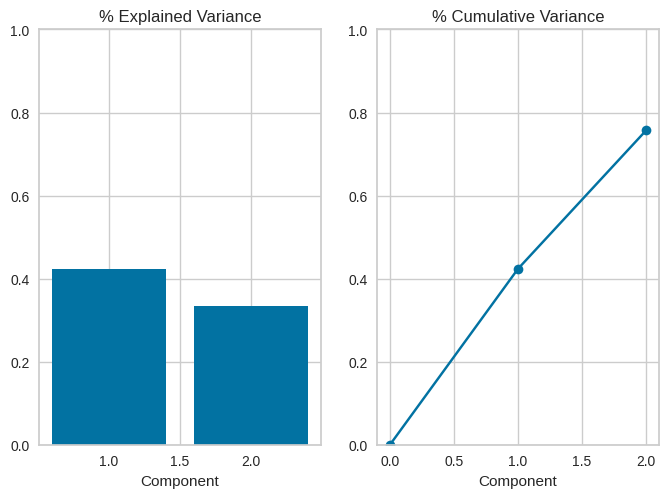

In [64]:
plot_variance(pca)

***
## 5.2 RFM scored

In [ ]:
if config["model"]["rfm_scored"]["do"]:
    data_rfm.info()

In [ ]:
if config["model"]["rfm_scored"]["do"]:
    split = np.array_split(data_rfm.iloc[:, 0], 5)

    split[0] = np.full((1, len(split[0])), 1)
    split[1] = np.full((1, len(split[1])), 2)
    split[2] = np.full((1, len(split[2])), 3)
    split[3] = np.full((1, len(split[3])), 4)
    split[4] = np.full((1, len(split[4])), 5)
    score = np.hstack((split[0], split[1], split[2], split[3], split[4])).flatten()

    data_rfm = data_rfm.sort_values(by="Récence", ascending=False)
    data_rfm["Récence_Score"] = score

    data_rfm = data_rfm.sort_values(by="Fréquence", ascending=False)
    data_rfm["Fréquence_Score"] = score

    data_rfm = data_rfm.sort_values(by="Montant", ascending=False)
    data_rfm["Montant_Score"] = score

In [ ]:
if config["model"]["rfm_scored"]["do"]:
    data_rfm.head()

In [ ]:
if config["model"]["rfm_scored"]["do"]:
    data_rfm_score = data_rfm.iloc[:, 3:6]

In [ ]:
display = None
if config["model"]["rfm_scored"]["do"]:
    display = data_rfm_score.head()
display

In [ ]:
if config["model"]["rfm_scored"]["do"]:
    correlation_heatmap(data_rfm_score, figsize=(20, 5))

In [ ]:
if config["model"]["rfm_scored"]["do"]:
    elbow(data_rfm_score.copy(), (2, 12))

In [ ]:
if config["model"]["rfm_scored"]["do"]:
    elbow_calinski_harabasz(data_rfm_score.copy(), (2, 12))

In [ ]:
if config["model"]["rfm_scored"]["silhouette"]:
    silhouette(data_rfm_score.copy(), 4)

Silhouette for n=4  
![alt text](plots/kmeans_4n_rfm_score.png "Silhouette for n=4")

In [ ]:
if config["model"]["rfm_scored"]["do"]:
    rfm_scored_3d_scatterplot(data_rfm.copy(), 4)

In [ ]:
if config["model"]["rfm_scored"]["do"]:
    data_rfm.head()

In [ ]:
explain = None
if config["model"]["rfm_scored"]["do"]:
    explain = rfm_scored_explain(data_rfm.copy(), 4)

In [ ]:
explain

***
## 5.3 Personae

### 5.3.1 Descriptive features identification

In [ ]:
if config["model"]["personae"]["do"]:
    data = fe_id_remove(data, diff=["customer_id", "order_id", "product_id"])
    data = fe_recency(data)
    data = fe_price(data)
    data = fe_volume(data)
    data = fe_frequency(data)

In [ ]:
data.head()

In [ ]:
sns.countplot(data=data, x="product_category_name")

In [ ]:
sns.kdeplot(x="frequency", data=data, shade=True)

In [ ]:
sns.kdeplot(x="price_sum", data=data, shade=True)

In [ ]:
sns.kdeplot(x="freight_value", data=data, shade=True)

In [ ]:
sns.kdeplot(x="recency", data=data, shade=True)

***
### 5.3.2 ...

In [ ]:
descriptive_features = ["frequency", "recency", "price_sum", "product_category_name"]
data_persona = data.loc[:, descriptive_features]

In [ ]:
data_persona.describe()

Segments:  
frequency > clients qui ont achetés 1 fois / clients qui ont achetés plus d'une fois --> 2 segments  
recency > clients qui ont achetés il y a moins de 4 mois, entre 4 et 7 mois, entre 7 et 1 an, il y a plus d'un an --> 4 segments  
price_sum > clients qui ont acheté pour moins de 49 €, entre 49 et 91€, entre 91 et 164€, plus de 164€ --> 4 segments  

In [ ]:
sns.boxplot(data=data_persona, y="frequency")

In [ ]:
sns.boxplot(data=data_persona, y="recency")

In [ ]:
data_persona["price_sum"] = data_persona[data_persona["price_sum"] < 1200]["price_sum"]
sns.boxplot(y=data_persona["price_sum"])

***
### 5.3.3 Personas

In [ ]:
frequency_onetime = data_persona[data_persona["frequency"] <= 1]
frequency_several = data_persona[data_persona["frequency"] > 1]

In [ ]:
frequency_onetime.describe()

In [ ]:
sns.kdeplot(data=frequency_onetime.loc[:, ["recency", "price_sum"]], shade=True)

In [ ]:
sns.boxplot(data=frequency_onetime, y="recency")

In [ ]:
frequency_onetime["price_sum"] = frequency_onetime[frequency_onetime["price_sum"] < 1200]["price_sum"]
sns.boxplot(y=frequency_onetime["price_sum"])

In [ ]:
frequency_several.describe()

In [ ]:
sns.kdeplot(data=frequency_several.loc[:, ["recency", "price_sum"]], shade=True)

In [ ]:
sns.boxplot(data=frequency_several, y="recency")

In [ ]:
frequency_several["price_sum"] = frequency_several[frequency_several["price_sum"] < 1200]["price_sum"]
sns.boxplot(y=frequency_several["price_sum"])

***
# 6 PCA

In [ ]:
display = None

if config["pca"]["do"]:
    pca_cols = data.select_dtypes(["int64", "float64"]).columns
    # pca_cols = pca_cols.append(data.loc[:, ["payment_type"]].columns)

    pca_data = data[pca_cols]
    pca_data = preprocess_data(pca_data)

    display = pca_data.head()

display

In [ ]:
if config["pca"]["do"]:
    pca = scree_plot(pca_data)

In [ ]:
if config["pca"]["do"]:
    pca = PCA(n_components=3)
    X = pca.fit_transform(pca_data)

In [ ]:
if config["pca"]["do"]:
    X = pd.DataFrame(data=X)
    X.head()

In [ ]:
if config["pca"]["do"]:
    elbow(X)

In [ ]:
if config["pca"]["do"]:
    silhouette(X, 4)

In [ ]:
if config["pca"]["do"]:
    kmean = KMeans(n_clusters=3)
    kmean.fit(X)
    y_pred = kmean.predict(X)
    X["pred_cluster"] = y_pred

In [ ]:
if config["pca"]["do"]:
    import plotly.express as px

In [ ]:
if config["pca"]["do"]:
    fig = px.scatter_3d(X, x=0, y=1, z=2, color="pred_cluster", labels={'x':'Feature 1', 'y':'Feature 2','z':'Feature 3'} )
    fig.show()

In [ ]:
if config["pca"]["do"]:
    rfm_data_explain = rfm_explain(pca_data.copy(), X, 4)